Cleaning and Preparing the data

In [2]:
pip install pandas numpy scikit-learn xgboost matplotlib seaborn joblib


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 3.7 MB/s eta 0:00:41
    --------------------------------------- 2.6/150.0 MB 4.2 MB/s eta 0:00:36
    --------------------------------------- 3.7/150.0 MB 4.4 MB/s eta 0:00:34
   - -------------------------------------- 4.7/150.0 MB 4.5 MB/s eta 0:00:33
   - -------------------------------------- 5.8/150.0 MB 4.5 MB/s eta 0:00:33
   - -------------------------------------- 6.8/150.0 MB 4.6 MB/s eta 0:00:32
   -- ------------------------------------- 7.9/150.0 MB 4.5 MB/s eta 0:00:32
   -- ------------------------------------- 8.9/150.0 MB 4.6 MB/s eta 0:00:31
   -- ------------------------------------- 10.0/150.0 MB 4.7 MB/s eta 0:00:30
   -- ------------------------------------- 11.0/150.0 MB 4.7 MB/s eta 0:00:30
   --- ------------------------------------ 12.1/150.0 MB 4.7 MB/s eta 0:00:30
   --- ------------------------------------ 13.1/150.0 MB 4.7 MB/s e

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
# Load the data
df = pd.read_csv('../data/raw/telco_train.csv')
print("Shape:", df.shape)
df.head()

Shape: (5634, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churned
0,4950-BDEUX,Male,0,No,No,35,No,No phone service,DSL,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,0
1,7993-NQLJE,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,0
2,7321-ZNSLA,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,...,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,0
3,4922-CVPDX,Female,0,Yes,No,26,Yes,No,DSL,No,...,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,0
4,2903-YYTBW,Male,0,Yes,Yes,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,0


In [5]:
# Basic Cleanup
# Drop columns with too many missing values or no predictive power
df.drop(columns=['customerID'], inplace=True)

In [15]:
# Fill missing values
df.ffill(inplace=True)  # Forward fill for simplicity

In [16]:
# Encode Categorical Variables
categorical_cols = df.select_dtypes(include='object').columns.tolist()

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [17]:
# Feature & Target Separation
print(df.columns)
X = df.drop(columns=['churned'])  # Ensure 'churned' is your binary target column
y = df['churned']

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'churned'],
      dtype='object')


In [18]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
# Scale Numeric Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Train Model
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train_scaled, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [22]:
# Evaluate
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.8344


In [23]:
# Save Model & Scaler
joblib.dump(model, '../app/model.pkl')
joblib.dump(scaler, '../app/scaler.pkl')

['../app/scaler.pkl']

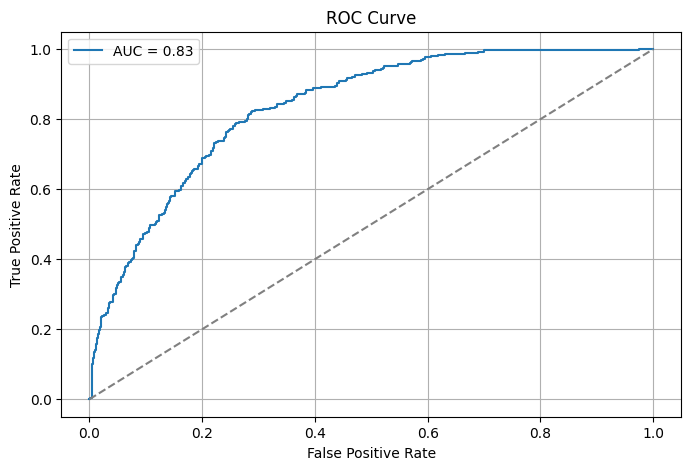

In [24]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
joblib.dump(X_train_scaled, '../app/X_train_scaled.pkl')
joblib.dump(X_test_scaled, '../app/X_test_scaled.pkl')
joblib.dump(y_train, '../app/y_train.pkl')
joblib.dump(y_test, '../app/y_test.pkl')

['../app/y_test.pkl']